In [100]:
import numpy as np

In [106]:
lidar =  np.load("/home/developer/ros2_ws/src/method_tester/lidar.npy")  # (N, 3)
mask = np.load("/home/developer/ros2_ws/src/method_tester/mask.npy")         # (H, W, 3)

lidar.shape, mask .shape

((12800, 3), (256, 256, 3))

In [ ]:
import numpy as np
import cv2
from scipy.spatial.transform import Rotation as R
import plotly.graph_objects as go

def lidar_to_colored_points(lidar, image, 
                            horizontal_samples=400, vertical_samples=32,
                            dx=0.0, dy=0.0, dz=10.0,
                            roll=0.0, pitch=0.0, yaw=0.0):
    # macierz rotacji
    rot = R.from_euler('xyz', [roll, pitch, yaw]).as_matrix()
    
    # transformacja LiDAR
    lidar_cam = (rot @ lidar.T).T + np.array([dx, dy, dz])
    x, y, z = lidar_cam[:,0], lidar_cam[:,1], lidar_cam[:,2]
    
    # dopasowanie rozmiaru maski
    mask_resized = cv2.resize(image, (horizontal_samples, vertical_samples), interpolation=cv2.INTER_NEAREST)
    mask_resized = np.flipud(mask_resized)
    mask_resized = np.fliplr(mask_resized)
    
    # konwersja kolorów do 1D
    colors_arr = mask_resized.reshape(-1, 3) / 255.0
    colors = ['rgb({},{},{})'.format(int(r*255), int(g*255), int(b*255)) for r,g,b in colors_arr]
    
    # filtracja NaN
    valid_idx = ~(np.isnan(x) | np.isnan(y) | np.isnan(z))
    x = x[valid_idx]
    y = y[valid_idx]
    z = z[valid_idx]
    colors = [c for i, c in enumerate(colors) if valid_idx[i]]
    
    return x, y, z, colors


def plot_lidar_points(x, y, z, colors, marker_size=2):
    """
    Rysuje chmurę punktów 3D w Plotly.
    """
    fig = go.Figure(data=[go.Scatter3d(
        x=x, y=y, z=z,
        mode='markers',
        marker=dict(
            size=marker_size,
            opacity=0.8,
            color=colors
        )
    )])
    
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        ),
        title="Chmura punktów LiDAR pokolorowana maską"
    )
    
    fig.show()
x,y,z,colors=lidar_to_colored_points(lidar,mask)

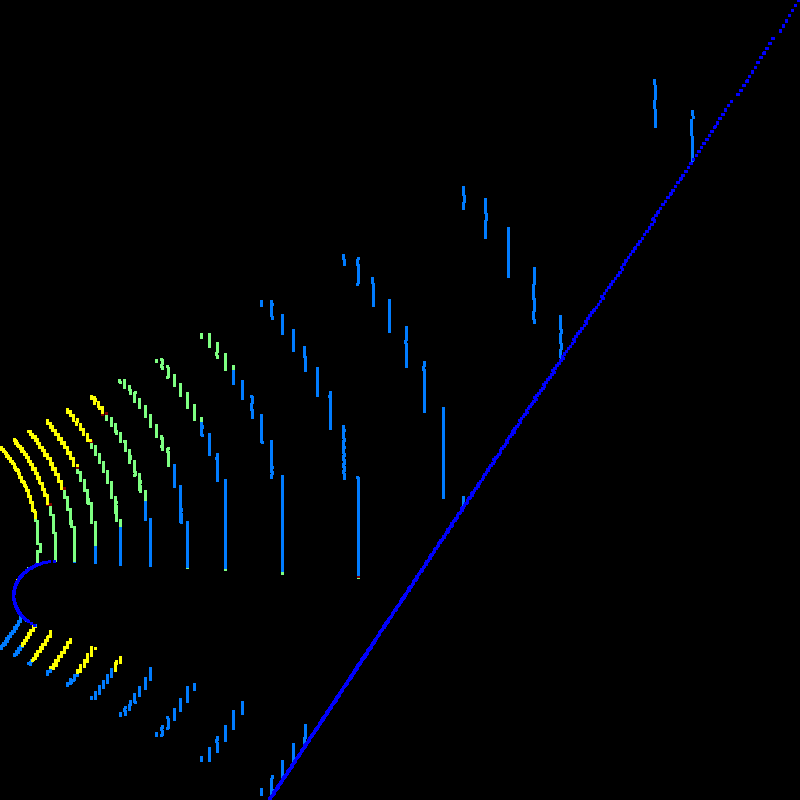

In [105]:
def lidar_to_image_fixed(x, y, colors, img_size=(800, 800), marker_size=1):
    """
    Zamienia punkty LiDAR na obraz numpy/PIL bez użycia matplotlib.
    Odwraca oś Y, żeby rzut odpowiadał wykresowi 3D w Plotly.
    """
    H, W = img_size
    img_array = np.zeros((H, W, 3), dtype=np.uint8)
    
    # normalizacja współrzędnych do zakresu [0, W-1], [0, H-1]
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x)) * (W-1)
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y)) * (H-1)
    
    # odwrócenie osi Y
    y_norm = H - 1 - y_norm
    
    for xi, yi, color in zip(x_norm, y_norm, colors):
        r, g, b = [int(c) for c in color[4:-1].split(',')]
        xi, yi = int(xi), int(yi)
        x_min = max(xi - marker_size//2, 0)
        x_max = min(xi + marker_size//2 + 1, W)
        y_min = max(yi - marker_size//2, 0)
        y_max = min(yi + marker_size//2 + 1, H)
        img_array[y_min:y_max, x_min:x_max] = [r, g, b]
    
    img_pil = Image.fromarray(img_array)
    return img_array, img_pil
top_array, top_img = lidar_to_image_fixed(x, y, colors, img_size=(800, 800), marker_size=2)
top_img.show()


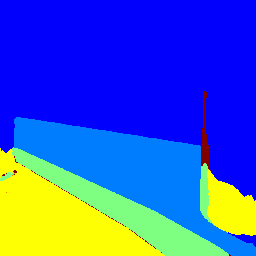

In [103]:
from PIL import Image

Image.fromarray(mask)